<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_04_04_survival_analysis_marginal_models_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 4.4 Marginal Models for Recurrent Events


Marginal models are a class of statistical approaches used in survival analysis to handle recurrent events data, where a subject can
experience multiple events over time (e.g., repeated hospitalizations, infections, or seizures). These models focus on estimating the
**population-averaged** (or marginal) effects of covariates on the event rate or mean number of events, without explicitly modeling the
dependence structure among recurrent events within the same individual. Instead, they rely on robust variance estimators (e.g., sandwich
estimators) to account for within-subject correlation, making them flexible when the exact form of dependence is unknown or complex.


### Key Features of Marginal Models


1.  **Population-Averaged Effects**: Marginal models estimate the average effect of covariates on the event rate across the entire
    population, rather than subject-specific effects. This is useful for understanding overall treatment effects in clinical trials or
    public health studies.

2.  **Robust Variance Estimation**: They use robust (sandwich) variance estimators to adjust standard errors for within-subject correlation,
    allowing valid inference even when the dependence structure is misspecified.

3, **Unconditional Risk Sets**: Marginal models typically define risk sets that include all subjects at risk for each event stratum,
ignoring the order of events. This contrasts with conditional models that may restrict risk sets based on prior event history.

4.  **Flexible Covariate Effects**: Covariates can have different effects on different event strata (e.g., first vs. second recurrence),
    allowing for heterogeneity in risk factors across events.


## Common Marginal Models

### Wei-Lin-Weissfeld (WLW) Model


A popular marginal model that treats each event stratum as a separate process, allowing for different baseline hazards and covariate effects
for each event. It uses a robust variance estimator to account for within-subject correlation.

-   Proposed by **Wei, Lin & Weissfeld (1989)** for **ordered recurrent events**.

-   Fits a **Cox proportional hazards model** for each event number (k):

$$
  \lambda_k(t | X) = \lambda_{k0}(t)\exp(\beta^\top X)
$$

-   Different baseline hazard for each event number (via `strata(event_number)`).

-   Usually assumes a **common covariate effect** (\beta) across events, though it can vary by stratum.

-   **Key features:**

    -   Each event order analyzed *marginally* — subjects contribute to all event orders (even if earlier events not yet occurred).
    -   **Death is treated as censoring** (no explicit handling as a terminal event).
    -   Uses **robust (sandwich)** variance to account for within-subject correlation.

-   **Interpretation:** WLW gives the *marginal hazard ratio* for the k-th event, adjusted for covariates, without modeling dependence
    between events or death.


### Marginal Mean Models


These models directly estimate the marginal mean function of the number of events over time, often using counting process techniques and
robust variance estimation.

-   Developed by **Ghosh & Lin (2000, 2002)** to handle **recurrent events with a terminating event (death)**.

-   It’s **not** a hazard model — it’s an *estimation procedure* for the **marginal mean number of recurrent events** by time (t):

$$
  M(t) = \int_0^t S(u), dR(u)
$$ where:

-   (S(u)): survival probability up to time (u)

-   (R(u)): cumulative hazard (rate) of recurrent events among survivors.

-   The two models (for death and recurrence) are fit separately (e.g., via `phreg()` in `mets`), and combined to estimate:

$$
  \widehat{M}(t) = \int_0^t \widehat{S}(u), d\widehat{R}(u)
$$

-   **Lin & Ghosh (2000)** derived *fast influence-function-based* standard errors for this estimator.

-   **Key features:**

    -   Explicitly incorporates **death as a terminal event** — no events after death.
    -   Provides a **population-level mean curve**: expected number of recurrences up to time *t*, accounting for death.
    -   Implemented in `mets::recurrentMarginal()`.

-   **Interpretation:** Gives an **absolute, interpretable summary** — e.g., *“By 3 years, patients in group A have an expected 1.8
    recurrences on average.”*


### Key Differences Between WLW and Marginal Mean Models


Both the **Wei–Lin–Weissfeld (WLW)** model and the **marginal mean method** deal with recurrent events, but they address **different
scientific questions**, use **different estimands**, and rely on **different modeling frameworks**.

| Aspect | **Wei–Lin–Weissfeld (WLW)** | **Lin & Ghosh (2000) Marginal Mean** |
|:---------------------------------|:--------------------------------------------|:------------------------------------------------------------|
| **Type of model** | *Cox regression model* (semiparametric hazard model) | *Nonparametric / semiparametric estimator* of cumulative mean function |
| **Quantity estimated** | *Hazard ratio* for each event order | *Expected number (mean) of recurrent events* up to time *t* |
| **Framework** | Regression modeling of time to each event | Marginal mean function accounting for death |
| **Focus** | *Instantaneous rate* of event occurrence | *Cumulative number* of events over time |


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316567 sha256=d13ededf775b7e5b6e8ba72dd90b6c7280c610fcea55d3020aa76322e4211ec5
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Implementation in R


The `mets` package in R provides tools for analyzing recurrent event data using both the WLW model and the marginal mean method.


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code
below:


In [ ]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'riskRegression',
		 'reda',
		 'mets'
		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


In [ ]:
%%R
install.packages(c("mets"), lib='drive/My Drive/R/')

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk riskRegression           reda 
          TRUE           TRUE           TRUE           TRUE           TRUE 
          mets 
          TRUE 


### Load Packages

In [ ]:
%%R
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:mets"           "package:reda"           "package:riskRegression"
 [4] "package:cmprsk"         "package:timereg"        "package:ggfortify"     
 [7] "package:tidycmprsk"     "package:ggsurvfit"      "package:survminer"     
[10] "package:ggpubr"         "package:survival"       "package:lubridate"     
[13] "package:forcats"        "package:stringr"        "package:dplyr"         
[16] "package:purrr"          "package:readr"          "package:tidyr"         
[19] "package:tibble"         "package:ggplot2"        "package:tidyverse"     
[22] "package:tools"          "package:stats"          "package:graphics"      
[25] "package:grDevices"      "package:utils"          "package:datasets"      
[28] "package:methods"        "package:base"          


### Marginal Mean of Recurrent Events


In studies where subjects may experience **repeated (recurrent) events** and eventually a **terminal event** (e.g., death), standard
recurrence analysis is biased if death is ignored, since no further events can occur after death.

To address this, the **marginal mean function** gives the *expected number of recurrent events by time* (t), accounting for both recurrence
and death processes.

Let

-   $R(t)$: cumulative hazard (rate) of recurrent events among survivors,
-   $S(t)$: survival probability (probability of being alive at time $t$).

Then the **marginal mean number of recurrent events** up to time $t$ is

$$
M(t) = \int_0^t S(u), dR(u)
$$

Two proportional hazards (Cox-type) models are fitted:

1.  **Recurrent event model:**

$$
   \lambda_r(t|x) = \lambda_{r0}(t)\exp(x^\top \beta_r)
$$

2.  **Death (terminal event) model:**

$$
   \lambda_d(t|x) = \lambda_{d0}(t)\exp(x^\top \beta_d)
$$

The **baseline survival function** is estimated from the death model as

$$
\widehat{S}(t|x=0) = \exp!\left(-\widehat{\Lambda}_d(t|x=0)\right)
$$

where $\widehat{\Lambda}_d(t|x=0)$ is the estimated cumulative baseline hazard for death.

The **cumulative recurrence rate** among survivors is estimated as

$\widehat{R}(t|x=0) = \widehat{\Lambda}_r(t|x=0$.

`Estimator of the Marginal Mean`

The estimator of $M(t)$ for the baseline group $(x=0)$ is

$$
\widehat{M}(t) = \int_0^t \widehat{S}(u|x=0), d\widehat{R}(u|x=0)
$$

In discrete form (numerical integration):

$$
\widehat{M}(t) \approx \sum_{u_i \le t} \widehat{S}(u_i), \Delta \widehat{R}(u_i)
$$

`Variance Estimation`

The **Lin and Ghosh (2000)** method provides a *fast, robust variance estimator* for $\widehat{M}(t)$, combining the variability from both
the recurrent and death models through a **sandwich (influence function) approach**.

`Interpretation`

$\widehat{M}(t)$ gives the **expected number of recurrent events** a typical subject would experience by time $t$, properly adjusted for
the fact that **death stops further recurrences**.


#### Data


The **`bladder1`** dataset in `survival` contains data from a bladder cancer study with *recurrent tumor events* and *death or censoring*.



In [ ]:
%%R
data(bladder1)

####  Prepare the data


Make sure time variables are compatible (entry, exit, event). The `bladder1` dataset already has a **counting process format**:
`Surv(start, stop, event)`.

We’ll rename and clean it for clarity.


In [ ]:
%%R
bl <- bladder1
bl$id <- as.numeric(bl$id)
bl$treatment <- as.factor(bl$treatment)

#### Fit the recurrent and death models


You’ll fit two separate **Cox models** (via `phreg` from `mets`):


In [ ]:
%%R
# recurrent event model
xr <- phreg(Surv(start, stop, status == 1) ~ cluster(id), data = bl)
# death model
dr <- phreg(Surv(start, stop, status == 2) ~ cluster(id), data = bl)

#### Plot baseline hazards

In [ ]:
%%R
# plot baseline hazards
par(mfrow = c(1, 2))
plot(dr, se = TRUE)
title(main = "Death model baseline hazard")
plot(xr, se = TRUE)
title(main = "Recurrent event baseline hazard")

#### Compute marginal mean using `recurrentMarginal`


Now apply `recurrentMarginal` directly using the `Event()` object:


In [ ]:
%%R
out <- recurrentMarginal(Event(start, stop, status) ~ cluster(id),
                         data = bl,
                         cause = 1,       # recurrence
                         death.code = 2)  # death

#### Summarize and plot the marginal mean function

[[1]]
   new.time       mean          se     CI-2.5%   CI-97.5% strata
2         1 0.00862069 0.008583451 0.001224665 0.06068294      0
5         2 0.03493783 0.017274367 0.013256686 0.09207821      0
15        3 0.12724741 0.032908302 0.076650334 0.21124375      0
30        4 0.27034716 0.051338848 0.186328330 0.39225162      0
34        5 0.30679571 0.052761927 0.219008945 0.42977060      0
39        6 0.35370433 0.057621064 0.257023784 0.48675165      0
47        7 0.43103693 0.064671880 0.321219556 0.57839826      0
50        8 0.45951851 0.073184154 0.336308900 0.62786700      0
54        9 0.49835529 0.076193875 0.369316148 0.67248074      0
59       10 0.54796513 0.080392962 0.411028181 0.73052360      0



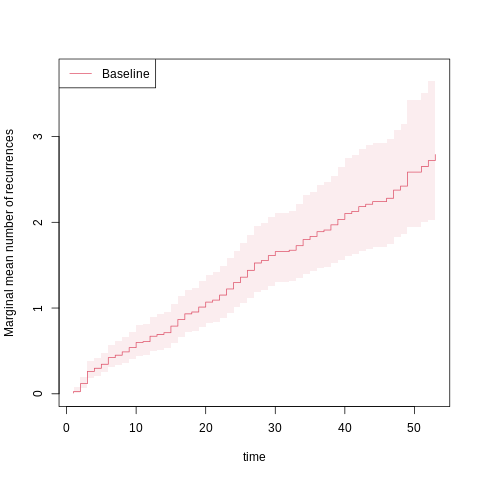

In [ ]:
%%R
plot(out, se = TRUE, col = 2, ylab = "Marginal mean number of recurrences")
summary(out, times = seq(1, 10, by = 1))

#### Add treatment stratification


If you want to compare by treatment (`rx`):


In [ ]:
%%R
out_strata <- recurrentMarginal(Event(start, stop, status) ~ strata(treatment) + cluster(id),
                                data = bl, cause = 1, death.code = 2)
summary(out_strata, times = seq(1, 10, by = 1))

[[1]]
   new.time       mean         se     CI-2.5%  CI-97.5% strata
2         1 0.02127660 0.02104903 0.003060586 0.1479107      0
3         2 0.04301573 0.02975345 0.011088215 0.1668756      0
7         3 0.13296017 0.05185917 0.061904587 0.2855751      0
13        4 0.27436524 0.07200617 0.164034169 0.4589061      0
14        5 0.29658746 0.07335981 0.182646458 0.4816087      0
16        6 0.34153696 0.07575677 0.221121799 0.5275260      0
20        7 0.43355179 0.09316435 0.284530892 0.6606213      0
21        8 0.45627906 0.10458715 0.291152315 0.7150573      0
23        9 0.50226215 0.11506574 0.320571165 0.7869306      0
27       10 0.59644501 0.12473571 0.395873990 0.8986361      0

[[2]]
   new.time       mean         se    CI-2.5%  CI-97.5% strata
1         1 0.00000000 0.00000000 0.00000000 0.0000000      0
2         2 0.03225806 0.03173351 0.00469114 0.2218187      1
4         3 0.09892473 0.05483553 0.03337878 0.2931833      1
10        4 0.31795368 0.12041263 0.15135761 0

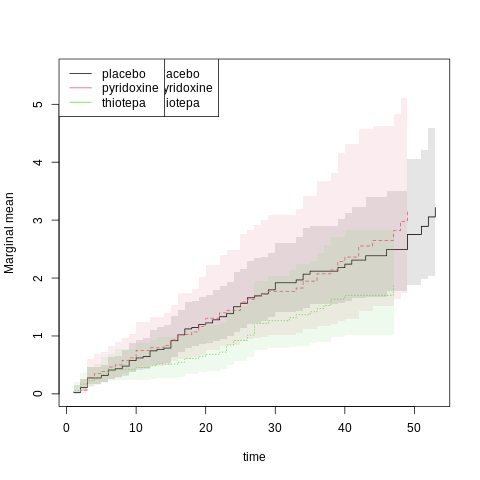

In [ ]:
%%R
plot(out_strata, se = TRUE, ylab = "Marginal mean", col = 1:3)
legend("topleft", legend = levels(bl$treatment), col = 1:3, lty = 1)



Above plots show the **expected number of recurrences** by time (t) for each treatment group, accounting for death. For example, at 5 years:
* Treatment 1 has an expected ~1.5 recurrences,
* Treatment 2 has ~1.2 recurrences,
* Treatment 3 has ~0.9 recurrences.
This suggests treatment 3 may be more effective in reducing recurrences, but formal statistical tests or confidence intervals should be used to confirm.



### WLW model — common covariate effect across event orders


The WLW model is a **marginal Cox-type model** for analyzing ordered recurrent events. Key points:

* It treats the (k)-th event for each subject as a separate (marginal) survival process.

* The hazard for the (k)-th event is modeled as

$$
  \lambda_k(t \mid X) = \lambda_{k0}(t),\exp(\beta^\top X),
$$

where ($\lambda_{k0}(t)$) is the baseline hazard for event order $k$.

* WLW typically **allows different baseline hazards** for different event orders (via stratification on event number) but **assumes a common regression coefficient** $beta$ across event orders unless you explicitly let (\beta) vary with (k).

* Because each subject contributes multiple correlated observations, standard errors must be adjusted; WLW uses a **robust (sandwich) variance estimator** (clustered by subject).

* **Risk sets** in WLW include all subjects who are under observation at time (t) for that particular event order — importantly, WLW does **not** require that subjects have experienced earlier events to be in the risk set for higher-order events (this is a marginal feature; contrasts with PWP conditional models).

**When to use**: when you want a marginal population-average effect of covariates on the hazard of recurrent events, and when you want separate baseline hazards for each event order.

You can implement WLW with `survival::coxph()` using:

* `strata(event_number)` to allow a different baseline hazard for each event order (k),
* `cluster(id)` to request robust standard errors (sandwich variance by subject),
* `Surv(start, stop, event)` (counting-process style) or `Surv(time, event)` depending on your data.



#### Data

In [ ]:
%%R
data(bladder1)         # survival::bladder1
bl <- bladder1

# create indicator for recurrence (1 = recurrence of interest)
bl$recur <- as.integer(bl$status == 1)

# event order variable (exists in bladder1 as 'enum')
table(bl$enum)


  1   2   3   4   5   6   7   8   9  10 
118  61  36  26  18  14   7   7   6   1 


####  Fit WLW model with common covariate effect

In [ ]:
%%R
# WLW: different baseline hazards by event order, common beta across orders
wlw_fit <- coxph(Surv(start, stop, recur) ~ strata(enum)
                 + treatment
                 + cluster(id), data = bl)
summary(wlw_fit)

Call:
coxph(formula = Surv(start, stop, recur) ~ strata(enum) + treatment, 
    data = bl, cluster = id)

  n= 292, number of events= 189 
   (2 observations deleted due to missingness)

                        coef exp(coef) se(coef) robust se      z Pr(>|z|)
treatmentpyridoxine  0.07479   1.07766  0.18951   0.20061  0.373    0.709
treatmentthiotepa   -0.16564   0.84735  0.19760   0.18345 -0.903    0.367

                    exp(coef) exp(-coef) lower .95 upper .95
treatmentpyridoxine    1.0777     0.9279    0.7273     1.597
treatmentthiotepa      0.8474     1.1801    0.5914     1.214

Concordance= 0.521  (se = 0.032 )
Likelihood ratio test= 1.25  on 2 df,   p=0.5
Wald test            = 1.14  on 2 df,   p=0.6
Score (logrank) test = 1.23  on 2 df,   p=0.5,   Robust = 1.26  p=0.5

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score tests do not).



* `strata(enum)` gives separate baseline hazards λ_{k0}(t) for each event number `k`.
* The coefficient for `treatment` is a **marginal (population-average) log hazard ratio** for recurrence, assumed the same across event orders.
* `cluster(id)` yields robust (sandwich) standard errors accounting for within-subject correlation.




####  Allow covariate effects to differ by event order


If you suspect the covariate effect differs by event number (k), include interactions between `rx` and a factor of `enum`. Keep `strata(enum)` so each stratum has its own baseline hazard:


In [ ]:
%%R
# let treatemnt effect vary by event number
wlw_fit_vary <- coxph(Surv(start, stop, recur) ~ strata(enum)
                      + treatment:factor(enum)
                      + cluster(id), data = bl)
summary(wlw_fit_vary)

Call:
coxph(formula = Surv(start, stop, recur) ~ strata(enum) + treatment:factor(enum), 
    data = bl, cluster = id)

  n= 292, number of events= 189 
   (2 observations deleted due to missingness)

                                         coef  exp(coef)   se(coef)  robust se
treatmentplacebo:factor(enum)1      3.830e-01  1.467e+00  3.025e-01  3.029e-01
treatmentpyridoxine:factor(enum)1   2.979e-02  1.030e+00  3.501e-01  3.581e-01
treatmentthiotepa:factor(enum)1            NA         NA  0.000e+00  0.000e+00
treatmentplacebo:factor(enum)2      3.505e-01  1.420e+00  3.933e-01  4.151e-01
treatmentpyridoxine:factor(enum)2   6.664e-01  1.947e+00  4.509e-01  5.187e-01
treatmentthiotepa:factor(enum)2            NA         NA  0.000e+00  0.000e+00
treatmentplacebo:factor(enum)3     -3.788e-01  6.847e-01  5.527e-01  3.150e-01
treatmentpyridoxine:factor(enum)3  -4.863e-01  6.149e-01  6.441e-01  5.673e-01
treatmentthiotepa:factor(enum)3            NA         NA  0.000e+00  0.000e+00
treatmentp

In [ ]:
%%R
# Alternatively specify main effects and interactions explicitly:
wlw_fit_vary2 <- coxph(Surv(start, stop, recur) ~ strata(enum) +
                         treatment * factor(enum)
                       - treatment + cluster(id), data = bl)
# (rx * factor(enum) - rx keeps only the interactions while keeping strata-based baselines)




* `treatemnt:factor(enum)` fits separate log-hazard effects of `rx` for each event order.




#### Model diagnostics & notes


* Check proportional hazards within each stratum (e.g., `cox.zph()` on each stratum separately).
* If you want standard (model-based) SEs, remove `cluster(id)` — but **do not**: you should use robust SEs for WLW.
* Compare WLW to alternatives:

  * **PWP (Prentice–Williams–Peterson)**: conditional on having had the previous event (risk sets restricted) — use `strata(enum)` *and* only put subjects at risk for k-th event after (k−1)-th event time or use `id` counting process with appropriate construction. Implement via `coxph(..., ties=...)` with start/stop editing or packages that directly implement PWP.
  * **Andersen–Gill (AG)**: treats recurrent events as one counting process (works via `coxph` with `cluster(id)` but assumes independent increments/  multiplicative intensity; interprets differently).



#### Short interpretation example (from the `summary()`)


Suppose `summary(wlw_fit)` gives for `treatment`:

* coef = -0.4, exp(coef) = 0.67, robust SE, p-value < 0.05.

Then: on average across event orders, the treatment `treatment` is associated with a **33% reduction** in the hazard of recurrence (WLW marginal hazard ratio ≈ 0.67), accounting for within-subject correlation via robust SEs.



#### Quick checklist when doing WLW in practice


* Use counting-process style (`Surv(start, stop, status)`) if you have interval data.
* Use `strata(enum)` to let baseline hazards vary by event order.
* Use `cluster(id)` for robust variance.
* Decide whether effects should be common across orders or allowed to vary (interactions).
* Compare to PWP and AG models if you need conditional or subject-specific interpretations.



## Summary and Conclusion


Marginal models provide a flexible framework for analyzing recurrent event data, focusing on population-average effects while accounting for within-subject correlation. The **Wei–Lin–Weissfeld (WLW)** model is a popular choice for estimating marginal hazard ratios for ordered recurrent events, allowing different baseline hazards for each event order but typically assuming a common covariate effect. In contrast, the **marginal mean method** of Lin and Ghosh estimates the expected number of recurrent events over time while properly accounting for terminal events like death.

When choosing between these approaches, consider your scientific question:

* If you want to understand how covariates affect the instantaneous risk of recurrence, WLW is appropriate.
* If you want to estimate the expected number of recurrences over time while accounting for death, the marginal mean method is more suitable.

Both methods rely on robust variance estimation to handle within-subject correlation, making them practical for real-world recurrent event data. Always check model assumptions and consider alternative models (e.g., PWP, AG) based on your research goals.


## Resources


* **Wei, Lin & Weissfeld (1989)** – *JASA*: Introduced the **WLW model**, treating each recurrent event as a separate process (marginal Cox model).
* **Ghosh & Lin (2000)** – *Biometrics*: Proposed **marginal mean model** for recurrent events accounting for death.
* **Cook & Lawless (2007)** – *The Statistical Analysis of Recurrent Events* (book): Comprehensive reference on WLW, PWP, AG, and marginal mean models.
* **`survival`** → WLW and related models (`coxph()` with `strata(event)` and `cluster(id)`).
* **`mets`** → Fast marginal mean estimator (`recurrentMarginal()`).
* **`frailtypack`** → Joint frailty models for recurrent + terminal events.